In [ ]:
!git clone https://github.com/NVlabs/GroupViT

fatal: destination path 'GroupViT' already exists and is not an empty directory.


In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full==1.3.16 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.8.0/index.html
!pip install mmsegmentation==0.18.0
!pip install webdataset==0.1.103
!pip install timm==0.4.12
!pip install nltk ftfy regex tqdm termcolor==1.1.0 diffdist einops omegaconf

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.7 MB/s eta 0:11:27tcmalloc: large alloc 1147494400 bytes == 0x55f4d9c02000 @  0x7fd723d81615 0x55f4a0c9617c 0x55f4a0d7647a 0x55f4a0c98f9d 0x55f4a0d8ad4d 0x55f4a0d0cec8 0x55f4a0d07a2e 0x55f4a0c9a88a 0x55f4a0d0cd30 0x55f4a0d07a2e 0x55f4a0c9a88a 0x55f4a0d09719 0x55f4a0d8bb76 0x55f4a0d08d95 0x55f4a0d8bb76 0x55f4a0d08d95 0x55f4a0d8bb76 0x55f4a0d08d95 0x55f4a0c9ace9 0x55f4a0cde579 0x55f4a0c99902 0x55f4a0d0cc4d 0x55f4a0d07a2e 0x55f4a0c9a88a 0x55f4a0d09719 0x55f4a0d07a2e 0x55f4a0c9a88a 0x55f4a0d088f6 0x55f4a0c9a7aa 0x55f4a0d08b4f 0x55f4a0d07a2e
     |█████████████████               | 1055.7 MB 1.5 MB/s eta 0:10:32tcmalloc: large alloc 1434370048 bytes == 0x55f51e258000 @  0x7fd723d81615 0x55f4a0c9617c 0x55f4a0d7647a 0x55f4a0c98f9d 0x55f4a0d8ad4d 0x55f4a0d0cec8 0x55f4a0d07a2e 0x55f4a0c9a88a 0x55f4a0d0cd30 0x55f4a0d07a2e 0x55f4a0c9a88a 0x55f4a0d09719 0x55f4a0d8bb76 0x55f4a0d08d

In [ ]:
import os
os.chdir('GroupViT')

In [ ]:
import os.path as osp
from collections import namedtuple

import mmcv
import numpy as np
import torch
from datasets import build_text_transform
from mmcv.cnn.utils import revert_sync_batchnorm
from mmcv.image import tensor2imgs
from mmcv.parallel import collate, scatter
from models import build_model
from omegaconf import read_write
from segmentation.datasets import (COCOObjectDataset, PascalContextDataset,
                                   PascalVOCDataset)
from segmentation.evaluation import (GROUP_PALETTE, build_seg_demo_pipeline,
                                     build_seg_inference)
from utils import get_config, load_checkpoint
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow

In [ ]:
checkpoint_url = 'https://github.com/xvjiarui/GroupViT/releases/download/v1.0.0/group_vit_gcc_yfcc_30e-74d335e6.pth'
cfg_path = 'configs/group_vit_gcc_yfcc_30e.yml'
output_dir = 'demo/output'
device = 'cpu'
vis_modes = ['input_pred_label', 'final_group']

PSEUDO_ARGS = namedtuple('PSEUDO_ARGS',
                         ['cfg', 'opts', 'resume', 'vis', 'local_rank'])

args = PSEUDO_ARGS(
    cfg=cfg_path, opts=[], resume=checkpoint_url, vis=vis_modes, local_rank=0)

cfg = get_config(args)

with read_write(cfg):
    cfg.evaluate.eval_only = True


In [ ]:
model = build_model(cfg.model)
model = revert_sync_batchnorm(model)
model.to(device)
model.eval()

load_checkpoint(cfg, model, None, None)

text_transform = build_text_transform(False, cfg.data.text_aug, with_dc=False)
test_pipeline = build_seg_demo_pipeline()


2022-03-26 01:14:01,499 - root - INFO - ==============> Resuming form https://github.com/xvjiarui/GroupViT-1/releases/download/v1.0.0/group_vit_gcc_yfcc_30e-74d335e6.pth....................
Downloading: "https://github.com/xvjiarui/GroupViT-1/releases/download/v1.0.0/group_vit_gcc_yfcc_30e-74d335e6.pth" to /root/.cache/torch/hub/checkpoints/group_vit_gcc_yfcc_30e-74d335e6.pth


Use load_from_http loader


  0%|          | 0.00/213M [00:00<?, ?B/s]

2022-03-26 01:14:06,191 - root - INFO - <All keys matched successfully>


In [ ]:
def inference(dataset, additional_classes, input_img):
    if dataset == 'voc' or dataset == 'Pascal VOC':
        dataset_class = PascalVOCDataset
        seg_cfg = 'segmentation/configs/_base_/datasets/pascal_voc12.py'
    elif dataset == 'coco' or dataset == 'COCO':
        dataset_class = COCOObjectDataset
        seg_cfg = 'segmentation/configs/_base_/datasets/coco_object164k.py'
    elif dataset == 'context' or dataset == 'Pascal Context':
        dataset_class = PascalContextDataset
        seg_cfg = 'segmentation/configs/_base_/datasets/pascal_context.py'
    else:
        raise ValueError('Unknown dataset: {}'.format(args.dataset))
    with read_write(cfg):
        cfg.evaluate.seg.cfg = seg_cfg

    dataset_cfg = mmcv.Config()
    dataset_cfg.CLASSES = list(dataset_class.CLASSES)
    dataset_cfg.PALETTE = dataset_class.PALETTE.copy()

    if len(additional_classes) > 0:
        additional_classes = additional_classes.split(',')
        additional_classes = list(
            set(additional_classes) - set(dataset_cfg.CLASSES))
        dataset_cfg.CLASSES.extend(additional_classes)
        dataset_cfg.PALETTE.extend(GROUP_PALETTE[np.random.choice(
            list(range(len(GROUP_PALETTE))), len(additional_classes))])
    seg_model = build_seg_inference(model, dataset_cfg, text_transform,
                                    cfg.evaluate.seg)

    device = next(seg_model.parameters()).device
    # prepare data
    data = dict(img=input_img)
    data = test_pipeline(data)
    data = collate([data], samples_per_gpu=1)
    if next(seg_model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        data['img_metas'] = [i.data[0] for i in data['img_metas']]
    with torch.no_grad():
        result = seg_model(return_loss=False, rescale=True, **data)

    img_tensor = data['img'][0]
    img_metas = data['img_metas'][0]
    imgs = tensor2imgs(img_tensor, **img_metas[0]['img_norm_cfg'])
    assert len(imgs) == len(img_metas)

    out_file_dict = dict()
    for img, img_meta in zip(imgs, img_metas):
        h, w, _ = img_meta['img_shape']
        img_show = img[:h, :w, :]

        ori_h, ori_w = img_meta['ori_shape'][:-1]
        img_show = mmcv.imresize(img_show, (ori_w, ori_h))

        for vis_mode in vis_modes:
            out_file = osp.join(output_dir, 'vis_imgs', vis_mode,
                                f'{vis_mode}.jpg')
            seg_model.show_result(img_show, img_tensor.to(device), result,
                                  out_file, vis_mode)
            out_file_dict[vis_mode] = out_file

    return out_file_dict

In [ ]:
voc_results = inference('voc', [], 'demo/examples/voc.jpg')

2022-03-26 01:14:08,245 - root - INFO - Building GroupViTSegInference with 21 classes, test_cfg=Config (path: None): {'bg_thresh': 0.95, 'mode': 'slide', 'stride': (224, 224), 'crop_size': (448, 448)}, with_bg=True


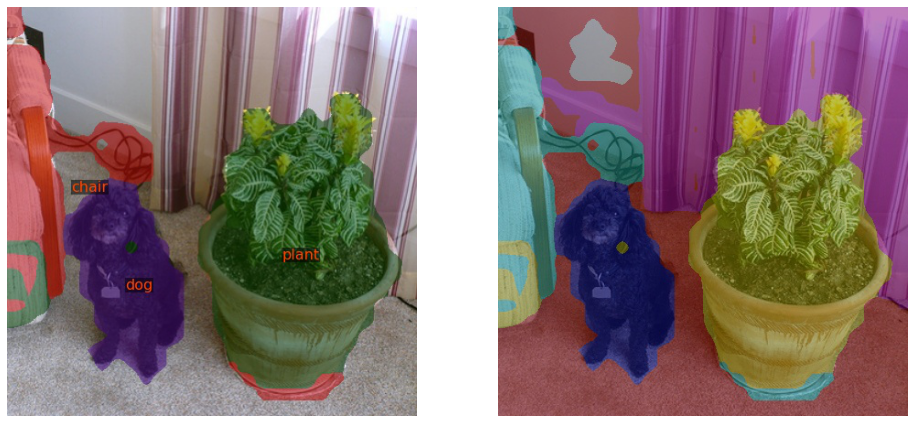

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
dpi = fig.get_dpi()
fig.set_size_inches(900/ dpi, 448 / dpi)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
axes[0].axis('off')
axes[0].imshow(Image.open(voc_results['input_pred_label']))
axes[1].axis('off')
axes[1].imshow(Image.open(voc_results['final_group']))
plt.show()